# Libraries

In [1]:
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path
from tqdm import tqdm
import networkx as nx
import networkx.algorithms.community as nx_comm
from tsnmf import TSNMF
from sklearn.feature_extraction.text import CountVectorizer

# Importing data

We import the data in the `parquet` format. Specify below the correct path:

In [2]:
path_to_parquet_data = Path('./data/infl-en-dde')

In [3]:
df1 = pq.read_table(path_to_parquet_data / 'df1e.parquet').to_pandas()
df2 = pq.read_table(path_to_parquet_data / 'df2e.parquet').to_pandas()
df3 = pq.read_table(path_to_parquet_data / 'df3e.parquet').to_pandas()
df4 = pq.read_table(path_to_parquet_data / 'df4e.parquet').to_pandas()
df5 = pq.read_table(path_to_parquet_data / 'df5e.parquet').to_pandas()

# Filtering and joining

We filter out the retweets, and merge the `df1` dataframe with the `df4` (hashtags):

In [4]:
no_retweets_mask = df1['retweetbody'].isnull()
df1 = df1[no_retweets_mask]

In [5]:
df1 = df1.merge(df4, how='left', left_on='id', right_on='id')

In [6]:
df1.head()

,id,verb,userid,inreplyto,link,body,retweetbody,tweet_dt,postedtime_x,retweetcount,favoritescount,generator,locationname,locationcode,hashtag,postedtime_y
0,"tag:search.twitter.com,2005:1000121300550062080",post,id:twitter.com:507547334,None,http://twitter.com/Bill_Dykes/statuses/1000121...,Heading into the Memorial Day weekend those in...,None,2018-05-25,2018-05-25T21:07:54.000Z,0,0.0,LinkedIn,None,None,NaN,NaN
1,"tag:search.twitter.com,2005:1000138945731031040",post,id:twitter.com:223565922,None,http://twitter.com/SoPhillyFred/statuses/10001...,Retweeted Ron Paul (@RonPaul):\n\nInflation is...,None,2018-05-25,2018-05-25T22:18:01.000Z,0,0.0,Facebook,None,None,NaN,NaN
2,"tag:search.twitter.com,2005:1000149645920735232",post,id:twitter.com:1252224511,None,http://twitter.com/EnergyPhilFlynn/statuses/10...,"Oil prices fall on talk of hike in production,...",None,2018-05-25,2018-05-25T23:00:32.000Z,0,0.0,Twitter Web Client,None,None,GoogleAlerts,2018-05-25
3,"tag:search.twitter.com,2005:1000562796646428673",post,id:twitter.com:992334290,None,http://twitter.com/JeanSwenson2/statuses/10005...,Gas prices up 60 cents over a year ago. And i...,None,2018-05-27,2018-05-27T02:22:14.000Z,0,0.0,Twitter Web Client,None,None,NaN,NaN
4,"tag:search.twitter.com,2005:1001436242440085504",post,id:twitter.com:21130921,None,http://twitter.com/WFAE/statuses/1001436242440...,"To Lower Your Medicare Drug Costs, Ask Your Ph...",None,2018-05-29,2018-05-29T12:13:00.000Z,0,0.0,Buffer,None,None,NaN,NaN


# Data cleaning

## Cleaning & lemmatization

We preprocess the text data contained in the body of the tweets. The preprocessing comprises many steps, such as removing stop words, emojis and so on (read the `data_preprocessing` function in the `dde.preprocessing.cleaning` module):

In [7]:
from dde.preprocessing.cleaning import data_preprocessing

tqdm.pandas()

df1_cleaned = df1.copy()
df1_cleaned['body'] = df1['body'].progress_apply(lambda x: data_preprocessing(x))

100%|██████████| 961064/961064 [00:24<00:00, 39304.99it/s]


After the cleaning we tokenize and lemmatize the body of the tweets, we will leverage the `lemmatize` function for this task (this section is commented out since it takes a lot of time):

In [8]:
# from dde.preprocessing.nltk_processing import remove_stopwords, lemmatize
# from tqdm import tqdm
# tqdm.pandas()
#
# df1_lemmatized = df1_cleaned.copy()
# # tokenize, lemmatize and remove the stopwords of the tweers
# df1_lemmatized['body'] = df1_cleaned['body'].progress_apply(lambda x: lemmatize(x))
# df1_lemmatized['body'] = df1_lemmatized['body'].progress_apply(lambda x: remove_stopwords(x))

Here we import the result of the process above:

In [9]:
df1_lemmatized = pd.read_csv("data/tokenized_lemmatized_df1/df1_lemmatized.csv", converters={"body": lambda x: x.strip("[]").replace("'","").split(", ")}, index_col=0)

## Remove bots

Here we remove the bots from `df1`, this is done leveraging the `generator` feature in `df1` (this section is commented out since it takes a lot of time) :

In [10]:
# generator = df1['generator'].unique()
# for i in generator:
#     print(i)

# no_bot = ['Twitter Lite',
#           'LinkedIn',
#           'Facebook',
#           'Twitter Web Client',
#           'Twitter for iPhone',
#           'Twitter for Android',
#           'Buffer',
#           'Twitter for iPad',
#           'SocialFlow',
#           'TweetDeck',
#           'Twitterrific for iOS',
#           'EconomicPoetry',
#           'Instagram',
#           'Google',
#           'WordPress.com',
#           'Twitter for Mac',
#           'Tumblr',
#           'Tweet Button',
#           'iOS',
#           'Adobe® Social',
#           'OS X',
#           'Twitter for Android',
#           'Twittascope',
#           'Twitter for Windows Phone',
#           'Twitter for Advertisers']
#
# df1_noBot = df1_cleaned[df1_cleaned['generator'].isin(no_bot)]
# df1_noBot.to_csv('/content/drive/MyDrive/Colab_TwitterIndicators/df1_NoBot.csv') #save the result in a csv file
#
# # FILTER THE OTHER DATASETS BASED ON THE NEW DF1
# df2_noBot = df2[df2['id'].isin(df1_noBot['id'])]
# df2_noBot.to_csv('/content/drive/MyDrive/Colab_TwitterIndicators/df2_NoBot.csv') #save the result in a csv file

Here we import the result of the process above:

In [11]:
df1_noBot = pd.read_csv('data/tokenized_lemmatized_df1/df1_NoBot.csv',  index_col=1)

/tmp/ipykernel_9049/3360411428.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df1_noBot = pd.read_csv('data/tokenized_lemmatized_df1/df1_NoBot.csv',  index_col=1)


In [12]:
df1_Lemma_NoBot = df1_lemmatized[df1_lemmatized['id'].isin(df1_noBot['id'])]

In [13]:
df1_Lemma_NoBot.head()

,id,verb,userid,inreplyto,link,body,retweetbody,tweet_dt,postedtime,retweetcount,favoritescount,generator,locationname,locationcode
1,"tag:search.twitter.com,2005:1000121300550062080",post,id:twitter.com:507547334,NaN,http://twitter.com/Bill_Dykes/statuses/1000121...,"[head, memorial, day, weekend, permian, basin,...",NaN,2018-05-25,2018-05-25T21:07:54.000Z,0,0.0,LinkedIn,NaN,NaN
2,"tag:search.twitter.com,2005:1000138945731031040",post,id:twitter.com:223565922,NaN,http://twitter.com/SoPhillyFred/statuses/10001...,"[retweeted, ron, paul, ronpaul, vicious, tax, ...",NaN,2018-05-25,2018-05-25T22:18:01.000Z,0,0.0,Facebook,NaN,NaN
3,"tag:search.twitter.com,2005:1000149645920735232",post,id:twitter.com:1252224511,NaN,http://twitter.com/EnergyPhilFlynn/statuses/10...,"[oil, price, fall, talk, hike, production, rai...",NaN,2018-05-25,2018-05-25T23:00:32.000Z,0,0.0,Twitter Web Client,NaN,NaN
6,"tag:search.twitter.com,2005:1000562796646428673",post,id:twitter.com:992334290,NaN,http://twitter.com/JeanSwenson2/statuses/10005...,"[gas, price, 60, cent, year, ago, make, americ...",NaN,2018-05-27,2018-05-27T02:22:14.000Z,0,0.0,Twitter Web Client,NaN,NaN
9,"tag:search.twitter.com,2005:1001436242440085504",post,id:twitter.com:21130921,NaN,http://twitter.com/WFAE/statuses/1001436242440...,"[lower, medicare, drug, cost, ask, pharmacist,...",NaN,2018-05-29,2018-05-29T12:13:00.000Z,0,0.0,Buffer,NaN,NaN


In [14]:
df1_lemmatized = df1_Lemma_NoBot.copy()

## Divide professionals and 'man-on-the-street'

Here we divide the `df1` into professionals and man-on-the-street, this is done by clustering their user-bio trough K-means (this section is commented out since it takes a lot of time):

In [15]:
# #take only the twitter with the user bio
# df2_Bio = df2_noBot['userBio'].notnull()
# #filter the twitter according to the user bio, dividing them in professionals and men of the street
# new_df2 = df2_noBot[df2_Bio]
#
# # TEXT CLUSTERING USING K MEANS ON THE USER BIO IN ORDER TO IDENTIFY THE TOPICS AND THEN 'CLASSIFY' THE USERS
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
#
# documents = new_df2['userBio'].values.astype("U")
# vectorizer = TfidfVectorizer(stop_words='english')
# features = vectorizer.fit_transform(documents)
#
# # CLUSTERING
# k = 7 # best_k
# model = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=1,random_state=457)
# model.fit(features)
#
# new_df2['cluster'] = model.labels_
#
# print("Cluster centroids: \n")
# order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names_out()
#
# for i in range(k):
#     print("Cluster %d:" % i)
#     for j in order_centroids[i, :40]: #print out 30 feature terms of each cluster
#         print (' %s' % terms[j])
#     print('------------')
#
# #creation of the labels (0 = professionals , 1 = men of the street)
# Label = {0 : 1, 1 : 1, 2 : 0 , 3 : 1, 4 : 0 , 5 : 0, 6 : 1}
# new_df2['LABEL'] = new_df2['cluster'].map(Label)
# new_df2.head()
#
# del new_df2['cluster']
#
# # count occurrences of 0 and 1
# new_df2['LABEL'].value_counts(dropna=False)
#
# df_professionals = new_df2[new_df2.LABEL == 0]
# df_men = new_df2[new_df2.LABEL == 1]
#
# del df_professionals['LABEL']
# del df_professionals['Unnamed: 0']
# df_professionals.to_csv('/content/drive/MyDrive/Colab_TwitterIndicators/df_professionals.csv')
#
# del df_men['LABEL']
# del df_men['Unnamed: 0']
# df_men.to_csv('/content/drive/MyDrive/Colab_TwitterIndicators/df_men.csv')

# Building the hashtag graph

In this section we build the hashtag graph, the details of how this is done is explained in the slides.

## Data preprocessing

We first preprocess the dataframe to build the graph:

In [16]:
# dataset containing the tweets with the hashtags
df1_hashtags = df1['hashtag'].dropna().apply(lambda x: x.lower())

# filter the df1 based on the df with the hashtags
df1_only_hashtags = df1.loc[df1_hashtags.index]
df1_only_hashtags['hashtag'] = df1_only_hashtags['hashtag'].apply(lambda x: x.lower())

# Put in a list all the hashtags in a tweet and take the unique id of the tweet. we do this in order to form the community 
df1_aggr = df1.copy()
df1_aggr = df1_only_hashtags.groupby(['id'])[
    ['hashtag']].agg(lambda x: list(x)).reset_index()

## Defining the graph

In [17]:
from dde.topic_modeling.graph_functions import *

G = nx.Graph()
G.add_nodes_from(df1_hashtags.to_list())
nx.isolates(G)

<generator object isolates.<locals>.<genexpr> at 0x7fc135d39ee0>

In [18]:
add_edges_to_graph(df1_aggr,G)
less_connected_comunities(G, threshold = 5)

In [19]:
print(len(G.nodes))
print(len(G.edges))

2099
4551


## Detecting the communities

Now we detect the communities in the graph by using the *Louvain method*:

In [20]:
from dde.topic_modeling.graph_functions import *

comm = nx_comm.louvain_communities(G, resolution=1, seed=123)

# take only the communities that are larger than 5
communities = [community for community in comm if len(community) > 5]

`labels` will be the matrix that contains the community identification for each tweet:

In [21]:
labels = create_labels_matrix(df1_lemmatized, df1_aggr, communities)

# Topic modeling

In this final section we will infer the topics for the body of the tweets. We will use two methods: TSNMF and LDA.

## Vectorization

We first prepare the data so that it can be processed by the topic modeling methods, in particular use an embedding by count vectors:

In [22]:
text_corpus = df1_lemmatized['body'].progress_apply(lambda x: ' '.join(x))

100%|██████████| 536782/536782 [00:00<00:00, 887420.95it/s]


In [23]:
complete_text_corpus = text_corpus.str.cat(sep=', ')

In [24]:
vectorizer = CountVectorizer()

# text_corpus = ... here the full body of tweets ...
vectorizer.fit(text_corpus)

CountVectorizer()

In [25]:
# X is the feature matrix it has number of rows equal to the number of tweets and columns equal to the features
X = vectorizer.transform(text_corpus)

## TSNMF

In [26]:
from dde.utilities import *

In [27]:

n_components = len(communities)
tsnmf = TSNMF(n_components=n_components, random_state=1)
W = tsnmf.fit(X, labels=labels) # document X topic_matrix
H = tsnmf.components_

Below we plot the top 10 words for each topic, with their respective weight:

In [28]:
feat_names = vectorizer.get_feature_names_out()
n_top_words = 10
# plot_top_words(tsnmf, feat_names, n_top_words, 'Topics')

## LDA

In [29]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = n_components,
                                random_state=1,
                                verbose=7,
                                n_jobs=12)

res_lda = lda.fit(X)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   16.9s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   20.0s remaining:   40.0s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   22.9s remaining:   16.4s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   24.0s remaining:    4.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   25.2s finished


iteration: 1 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   14.0s remaining:   28.1s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   16.8s remaining:   12.0s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   17.5s remaining:    3.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   17.8s finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   14.1s remaining:   28.1s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   16.9s remaining:   12.1s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   17.4s remaining:    3.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   18.1s finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   12.5s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   14.7s remaining:   29.5s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   15.6s remaining:   11.1s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   17.0s remaining:    3.4s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   17.8s finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   11.9s remaining:   23.7s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   15.5s remaining:   11.1s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   15.9s remaining:    3.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   16.2s finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   13.2s remaining:   26.4s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   14.2s remaining:   10.1s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   15.4s remaining:    3.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   15.9s finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   12.5s remaining:   25.0s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   14.2s remaining:   10.1s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   15.0s remaining:    3.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   15.4s finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   11.4s remaining:   22.8s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   13.4s remaining:    9.5s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   13.9s remaining:    2.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   14.4s finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:   10.2s remaining:   20.4s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   13.8s remaining:    9.8s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   14.2s remaining:    2.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   14.4s finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:    9.4s remaining:   18.9s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   13.1s remaining:    9.4s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   13.6s remaining:    2.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   13.9s finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:    8.7s remaining:   17.4s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   10.7s remaining:    7.6s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   10.9s remaining:    2.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   11.0s finished


In [30]:
feat_names = vectorizer.get_feature_names_out()
n_top_words = 10
# plot_top_words(res_lda, feat_names, n_top_words, 'Topics')

## Inference

In [31]:
from dde.topic_modeling.topic_modeling_functions import add_topic_label, filter_by_topic

In [32]:
lda_topic_matrix = lda.transform(X)
df1_topic = add_topic_label(lda_topic_matrix, df1_lemmatized)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:    6.9s remaining:   13.7s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:    9.7s remaining:    6.9s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    9.7s remaining:    1.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    9.9s finished


## WordClouds

Finally let's print some word clouds, to get a grasp of the topics

In [33]:
feat_names = vectorizer.get_feature_names_out()
model = lda

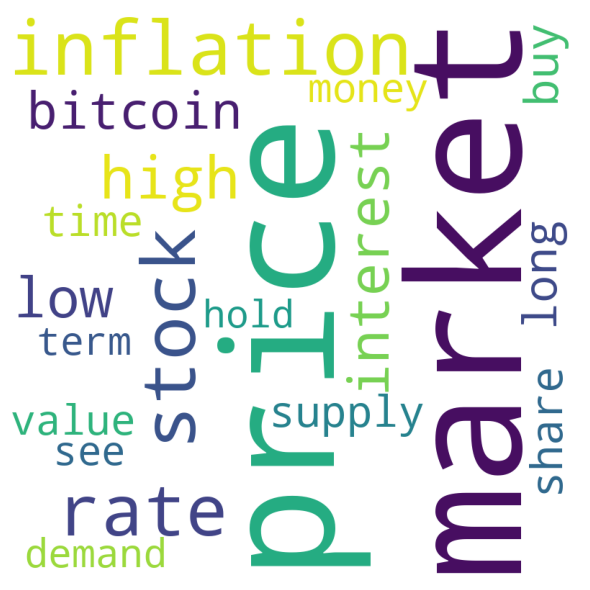

In [34]:
for i in get_weighted_words_topic(model, feat_names, n_top_words = 20):
    plot_word_cloud(i)
    break

# Saving the topics


From all the topics we select the ones listed below (manually selected) with their respective index:

* 2.0 : Inflation
* 12.0 : Financial market, trading
* 18.0 : Oil / Energy
* 26.0 : Bitcoin
* 30.0 : Real Estate

Now to generate the topic specific dataframes, we first import back the *professionals* and *man-on-the-streets* dataframes and use them to filter each topic specific dataframe.

In [35]:
df_men = pd.read_csv('data/tokenized_lemmatized_df1/df_men.csv', index_col=0)
df_professionals = pd.read_csv('data/tokenized_lemmatized_df1/df_professionals.csv', index_col=0)

/tmp/ipykernel_9049/3619939761.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_men = pd.read_csv('data/tokenized_lemmatized_df1/df_men.csv', index_col=0)
/tmp/ipykernel_9049/3619939761.py:2: DtypeWarning: Columns (0,6,7,8,10,20,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_professionals = pd.read_csv('data/tokenized_lemmatized_df1/df_professionals.csv', index_col=0)


In [36]:
df_lemmatized_men = df1_lemmatized[df1_lemmatized['id'].isin(df_men['id'])]
df_lemmatized_professionals = df1_lemmatized[df1_lemmatized['id'].isin(df_professionals['id'])]

In [37]:
df1_topic_men = add_topic_label(lda_topic_matrix, df_lemmatized_men)

/home/jack/Desktop/uni/DDE/project/dde/topic_modeling/topic_modeling_functions.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Max'] = df_topic_matrix['Max']


Finally we store the topic specific dataframes:

In [38]:
# CREATE THE DF FILTERED BY TOPICS FOR THE MEN OF THE STREET
df_inflation_men = filter_by_topic(df1_topic_men, 2.0)
df_financial_men = filter_by_topic(df1_topic_men, 12.0)
df_energy_men = filter_by_topic(df1_topic_men, 18.0)
df_bitcoin_men= filter_by_topic(df1_topic_men, 26.0)
df_real_estate_men = filter_by_topic(df1_topic_men, 30.0)

In [39]:
df_inflation_men.to_csv('df_inflation_men.csv')
df_financial_men.to_csv('df_financial_men.csv')
df_energy_men.to_csv('df_energy_men.csv') 
df_bitcoin_men.to_csv('df_bitcoin_men.csv')
df_real_estate_men.to_csv('df_real_estate_men.csv')

In [40]:
df1_topic_professionals = add_topic_label(lda_topic_matrix, df_lemmatized_professionals)

/home/jack/Desktop/uni/DDE/project/dde/topic_modeling/topic_modeling_functions.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Max'] = df_topic_matrix['Max']


In [41]:
# CREATE THE DF FILTERED BY TOPICS FOR THE PROFESSIONALS
df_inflation_experts = filter_by_topic(df1_topic_professionals, 2.0)
df_financial_experts = filter_by_topic(df1_topic_professionals, 12.0)
df_energy_experts = filter_by_topic(df1_topic_professionals, 18.0)
df_bitcoin_experts = filter_by_topic(df1_topic_professionals, 26.0)
df_real_estate_experts = filter_by_topic(df1_topic_professionals, 30.0)

In [42]:
df_inflation_experts.to_csv('df_inflation_experts.csv')
df_financial_experts.to_csv('df_financial_experts.csv')
df_energy_experts.to_csv('df_energy_experts.csv') 
df_bitcoin_experts.to_csv('df_bitcoin_experts.csv')
df_real_estate_experts.to_csv('df_real_estate_experts.csv')